## Introduction

## Data preparation

In [1]:
# !pip install workalendar
# !pip install openpyxl

import pandas as pd
import matplotlib.pyplot as plt
from workalendar.europe import Poland

from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV


### Loading the dataset

In [2]:
file_path = 'Car_accidents_Poland.xlsx'
df = pd.read_excel(file_path, engine='openpyxl')
df['Date'] = pd.to_datetime(df['Date'],format='%d.%m.%Y')
df.set_index('Date', inplace=True)
df = df.sort_index()
df.index.freq = 'D'
df

,Interventions,Arrested_red-handed,Detained_wanted,Drivers_under_the_influence_of_alcohol,Road_accidents,Killed_in_accidents,Injured_in_accidents
Date,,,,,,,
2022-06-15,18116,658,345,277,87,5,95
2022-06-16,15026,677,219,388,65,7,71
2022-06-17,18299,708,345,398,76,10,83
2022-06-18,18769,708,258,404,71,6,72
2022-06-19,16747,739,197,440,59,3,68
...,...,...,...,...,...,...,...
2024-06-14,17103,556,424,237,68,5,73
2024-06-15,17654,599,224,353,56,2,64
2024-06-16,15286,528,237,319,51,5,55


### Adding the exogenous data

In [3]:
df['Day_of_Week'] = df.index.day_name()
day_of_week_columns = pd.get_dummies(df['Day_of_Week'], dtype=float)
df = df.merge(day_of_week_columns, left_index=True, right_index=True)
df

,Interventions,Arrested_red-handed,Detained_wanted,Drivers_under_the_influence_of_alcohol,Road_accidents,Killed_in_accidents,Injured_in_accidents,Day_of_Week,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
Date,,,,,,,,,,,,,,,
2022-06-15,18116,658,345,277,87,5,95,Wednesday,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2022-06-16,15026,677,219,388,65,7,71,Thursday,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2022-06-17,18299,708,345,398,76,10,83,Friday,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-06-18,18769,708,258,404,71,6,72,Saturday,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2022-06-19,16747,739,197,440,59,3,68,Sunday,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-14,17103,556,424,237,68,5,73,Friday,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-06-15,17654,599,224,353,56,2,64,Saturday,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2024-06-16,15286,528,237,319,51,5,55,Sunday,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [4]:
cal = Poland()
def get_holidays(start_year, end_year):
    holidays = []
    for year in range(start_year, end_year + 1):
        holidays.extend(cal.holidays(year))
    return holidays
holidays = get_holidays(2022, 2024)
additional_holidays = [
    (pd.Timestamp('2024-10-31'), 'Halloween'),
    (pd.Timestamp('2024-11-29'), 'Andrzejki'),
    (pd.Timestamp('2024-05-02'), 'Day before Constitution Day'),
    (pd.Timestamp('2024-06-23'), 'Father\'s Day'),
    (pd.Timestamp('2024-12-24'), 'Christmas Eve'),

    (pd.Timestamp('2023-10-31'), 'Halloween'),
    (pd.Timestamp('2023-11-29'), 'Andrzejki'),
    (pd.Timestamp('2023-05-02'), 'Day before Constitution Day'),
    (pd.Timestamp('2023-06-23'), 'Father\'s Day'),
    (pd.Timestamp('2023-12-24'), 'Christmas Eve'),

    (pd.Timestamp('2022-10-31'), 'Halloween'),
    (pd.Timestamp('2022-11-29'), 'Andrzejki'),
    (pd.Timestamp('2022-05-02'), 'Day before Constitution Day'),
    (pd.Timestamp('2022-06-23'), 'Father\'s Day'),
    (pd.Timestamp('2022-12-24'), 'Christmas Eve')
]
all_holidays = holidays + additional_holidays
index_dates = df.index
valid_holidays = []
for date, name in all_holidays:
    if pd.Timestamp(date) in index_dates:
        valid_holidays.append((pd.Timestamp(date), name))
    preceding_day = pd.Timestamp(date) - pd.Timedelta(days=1)
    if preceding_day in index_dates:
        valid_holidays.append((preceding_day, f'{name} (Eve)'))
holidays_df = pd.DataFrame(valid_holidays, columns=['date', 'name'])
df['is_holiday'] = df.index.to_series().apply(lambda x: x in holidays_df['date'].values).astype(int)
df

,Interventions,Arrested_red-handed,Detained_wanted,Drivers_under_the_influence_of_alcohol,Road_accidents,Killed_in_accidents,Injured_in_accidents,Day_of_Week,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,is_holiday
Date,,,,,,,,,,,,,,,,
2022-06-15,18116,658,345,277,87,5,95,Wednesday,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
2022-06-16,15026,677,219,388,65,7,71,Thursday,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
2022-06-17,18299,708,345,398,76,10,83,Friday,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2022-06-18,18769,708,258,404,71,6,72,Saturday,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
2022-06-19,16747,739,197,440,59,3,68,Sunday,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-14,17103,556,424,237,68,5,73,Friday,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2024-06-15,17654,599,224,353,56,2,64,Saturday,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
2024-06-16,15286,528,237,319,51,5,55,Sunday,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0


In [5]:
cal = Poland()
cal.holidays(2024)

[(datetime.date(2024, 1, 1), 'New year'),
 (datetime.date(2024, 1, 6), 'Trzech Kroli'),
 (datetime.date(2024, 3, 31), 'Easter Sunday'),
 (datetime.date(2024, 4, 1), 'Easter Monday'),
 (datetime.date(2024, 5, 1), 'Labour Day'),
 (datetime.date(2024, 5, 3), 'Constitution Day'),
 (datetime.date(2024, 5, 19), 'Pentecost Sunday'),
 (datetime.date(2024, 5, 30), 'Corpus Christi'),
 (datetime.date(2024, 8, 15), 'Assumption of Mary to Heaven'),
 (datetime.date(2024, 11, 1), 'All Saints Day'),
 (datetime.date(2024, 11, 11), 'Independence Day'),
 (datetime.date(2024, 12, 25), 'Christmas Day'),
 (datetime.date(2024, 12, 26), 'Boxing Day')]

## Analysis for all Interventions

### Data visualization

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


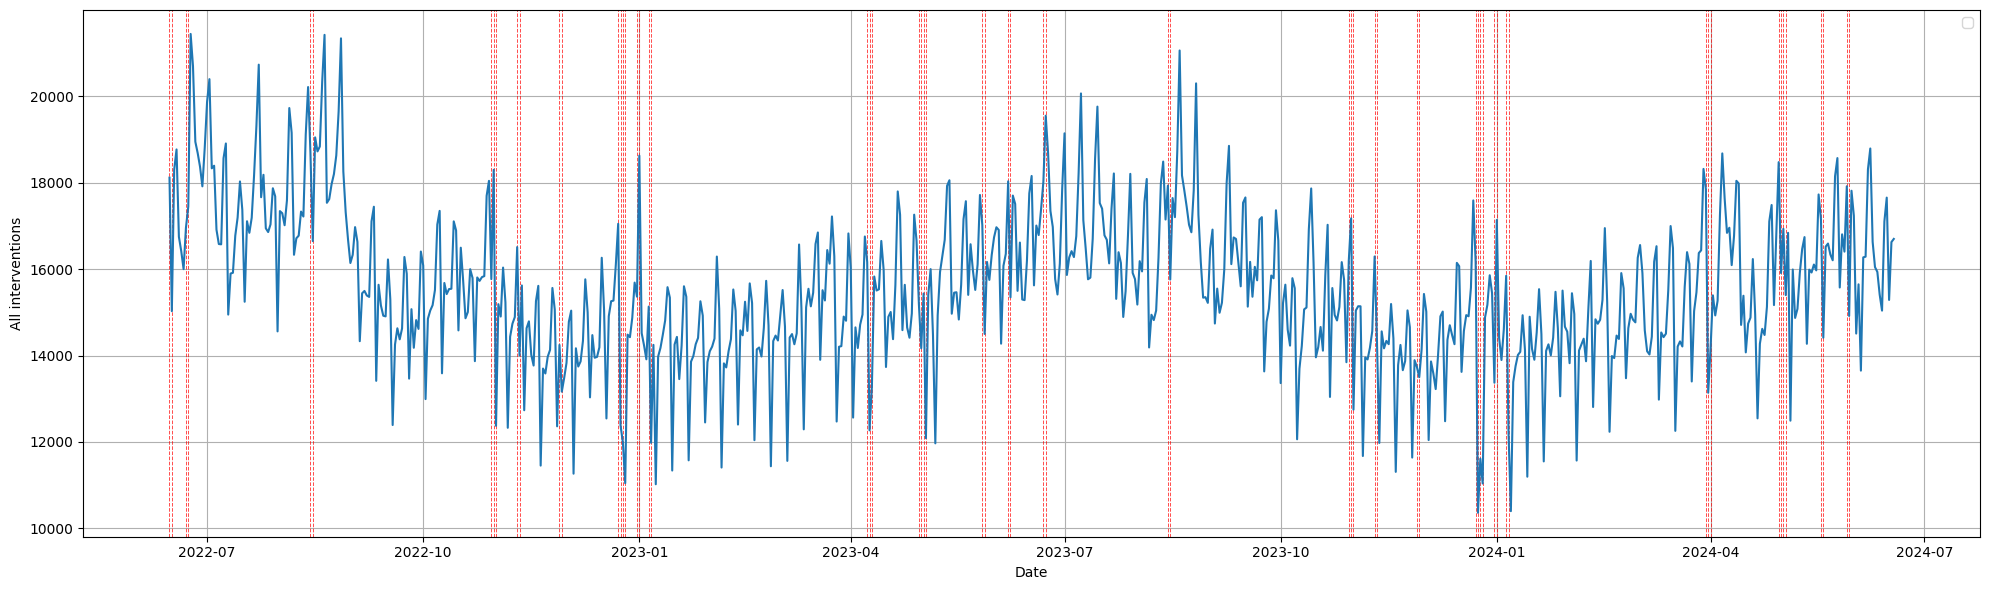

In [10]:
plt.figure(figsize=(20, 6))

holidays = df.index[df['is_holiday'] == True]
for holiday in holidays:
    plt.axvline(x=holiday, color='red', linestyle='--', linewidth=0.7, alpha=0.7)

plt.plot(df.index, df["Drivers_under_the_influence_of_alcohol	"])
plt.xlabel('Date')
plt.ylabel('Drivers under the influence of alcohol	')
plt.title('')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

In [7]:
# fig, axes = plt.subplots(nrows=len(columns), ncols=1, figsize=(10, 20), sharex=True)
# holidays = df.index[df['is_holiday'] == True]
# weekends = df.index[df['is_weekend'] == True]

# for i, col in enumerate(columns):
#     df[col].plot(ax=axes[i], title=col.strip(), legend=False)
#     axes[i].set_ylabel(col.strip())
    
#     # Plot vertical lines on holidays
#     for holiday in holidays:
#         axes[i].axvline(x=holiday, color='r', linestyle='--', lw=1)
      
#     for weekend in weekends:
#         axes[i].axvline(x=weekend, color='g', linestyle='--', lw=1)

# plt.tight_layout()
# plt.show()

### Holt-Winters analysis

### Autoarima analysis

In [8]:
train = df.iloc[:-7]
test  = df.iloc[-7:]
len(train)

start=len(train)
end=start+len(test)-1
len(train)

728

In [9]:
model_all_interventions = auto_arima(
    df["Interventions"],
    exogenous = df[["is_holiday", 'Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday']],
    start_p=0,
    start_q=0,
    max_p=5,
    max_q =5,
    seasonal=True,
    m=7,
    trace = True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True,
    n_jobs=-1
)
model_all_interventions.summary()

C:\Users\Adam\AppData\Roaming\Python\Python312\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=inf, Time=1.13 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=12940.170, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=12466.425, Time=0.47 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=12592.692, Time=0.67 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=12938.171, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=12865.184, Time=0.11 sec
 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=12375.514, Time=0.90 sec
 ARIMA(1,1,0)(2,0,1)[7] intercept   : AIC=12434.549, Time=2.62 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=12239.088, Time=1.50 sec
 ARIMA(1,1,0)(0,0,1)[7] intercept   : AIC=12641.827, Time=0.52 sec
 ARIMA(1,1,0)(1,0,2)[7] intercept   : AIC=12440.422, Time=2.77 sec
 ARIMA(1,1,0)(0,0,2)[7] intercept   : AIC=12549.453, Time=1.02 sec
 ARIMA(1,1,0)(2,0,2)[7] intercept   : AIC=inf, Time=3.44 sec


KeyboardInterrupt: 

In [ ]:
model_all_interventions = SARIMAX(train['Interventions'], exog=train[["is_holiday", 'Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday']], 
                      order=(2,1,0), seasonal_order=(1,0,1,7)).fit() #Best model:  ARIMA(2,1,0)(1,0,1)[7] intercept
model_all_interventions.summary()

In [ ]:
diagnostics = model_all_interventions.plot_diagnostics(figsize=(12, 12))

### Predicting for 1 week

In [ ]:
predictions_all_interventions=model_all_interventions.predict(start=start,exog=test[["is_holiday", 'Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday']],end=end,dynamic=False).rename('SARIMAX')
ax=test['Interventions'].plot(figsize=(14,5))
predictions_all_interventions.plot(legend=True)
for x in test.query('is_holiday==1').index:
    ax.axvline(x=x,color='r')

In [ ]:
mean_absolute_percentage_error(test['Interventions'],predictions_all_interventions)*100

## Analysis for drunken sailors

### Data visualization

In [ ]:
plt.figure(figsize=(20, 6)) 

holidays = df.index[df['is_holiday'] == True]
for holiday in holidays:
    plt.axvline(x=holiday, color='red', linestyle='--', linewidth=0.7, alpha=0.7)

plt.plot(df.index, df["Drivers_under_the_influence_of_alcohol"])
plt.xlabel('Date')
plt.ylabel('Drunken drivers')
plt.title('')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

### Holt-Winters analysis

In [ ]:
#

### Autoarima analysis

In [ ]:
train = df.iloc[:-7]
test  = df.iloc[-7:]
len(train)

start=len(train)
end=start+len(test)-1
len(train)

In [ ]:
model_drunken_drivers = auto_arima(
    df["Drivers_under_the_influence_of_alcohol"],
    exogenous = df[["is_holiday", 'Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday']],
    start_p=0,
    start_q=0,
    max_p=5,
    max_q =5,
    seasonal=True,
    m=7,
    trace = True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True,
    n_jobs=-1
)
model_drunken_drivers.summary()

In [ ]:
model_drunken_drivers = SARIMAX(train['Drivers_under_the_influence_of_alcohol'], exog=train[["is_holiday", 'Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday']], 
                      order=(4,1,1), seasonal_order=(0,0,2,7)).fit() # Best model:  ARIMA(4,1,1)(0,0,2)[7]          
model_drunken_drivers.summary()

In [ ]:
diagnostics = model_drunken_drivers.plot_diagnostics(figsize=(12, 12))

In [ ]:
predictions_drunken_drivers=model_drunken_drivers.predict(start=start,exog=test[["is_holiday", 'Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday']],end=end,dynamic=False).rename('SARIMAX')
ax=test['Drivers_under_the_influence_of_alcohol'].plot(figsize=(14,5))
predictions_drunken_drivers.plot(legend=True)
for x in test.query('is_holiday==1').index:
    ax.axvline(x=x,color='r')

In [ ]:
mean_absolute_percentage_error(test['Drivers_under_the_influence_of_alcohol'],predictions_drunken_drivers)*100

### Machine Learning approach - Random Forest Regression

In [ ]:
features = [col for col in df.columns if col not in ['Drivers_under_the_influence_of_alcohol', 'is_holiday', 'Day_of_Week']]

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

model = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_absolute_percentage_error')
grid_search.fit(train[features], train['Drivers_under_the_influence_of_alcohol'])
best_model = grid_search.best_estimator_
pred_drunken_drivers_rf = best_model.predict(test[features])

plt.figure(figsize=(14, 5))
test['Drivers_under_the_influence_of_alcohol'].plot(label='Actual drunken drivers')
pd.Series(pred_drunken_drivers_rf, index=test.index).plot(label='Random Forest Predictions', linestyle='--')
plt.legend()
plt.show()

mape_combined = mean_absolute_percentage_error(test['Drivers_under_the_influence_of_alcohol'], pred_drunken_drivers_rf) * 100
print(f'MAPE for Random Forest Predictions: {mape_combined:.2f}%')
print(f'Best hyperparameters: {grid_search.best_params_}')

Lags t-12

## Summary